In [5]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


# Part 1
Normalize data

$$ Y = \frac{X - \mu}{\sigma} $$


In [5]:
import pandas as pd

data = pd.read_csv('data.csv', sep=';')
quality = data['quality']
print(f'*** Quality range: {quality.min()} - {quality.max()} ***')

# normalize the data 
normed = data.copy()
for attr in normed.columns.difference(['quality']):
    normed[attr] -= data[attr].mean()
    normed[attr] /= data[attr].std()

# save to csv
normed.to_csv('data_normed.csv')

*** Quality range: 3 - 8 ***


**find the correlation coefficient between ph and sulphates**
Even though the formula is 
$$ \rho(X, Y) = \frac{\text{Cov}(X, Y)}{\sqrt{\text{Var}(X) \cdot \text{Var}(Y)}} $$
I don't have to device with the variances because the data is already normalized


In [6]:
import pandas as pd
import numpy as np

data = pd.read_csv('data_normed.csv')

# with build ins
r9_10 = data.corr()['pH']['sulphates']

# without build ins 
cov_ph_sul = np.mean((data['pH'] - data['pH'].mean()) * (data['sulphates'] - data['sulphates'].mean()))
cov_ph_sul, r9_10

(-0.19652462068942095, -0.19664760230437037)

Scatter plots of Cov
$$ \text{Cov}(X, Y) = \mathbb{E}\left[ (X - \mathbb{E}[X])(Y - \mathbb{E}[Y]) \right] $$

We use **seaborn** to create heatmaps for the correlation data

/home/kostiskak/anaconda3/envs/ai_env/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


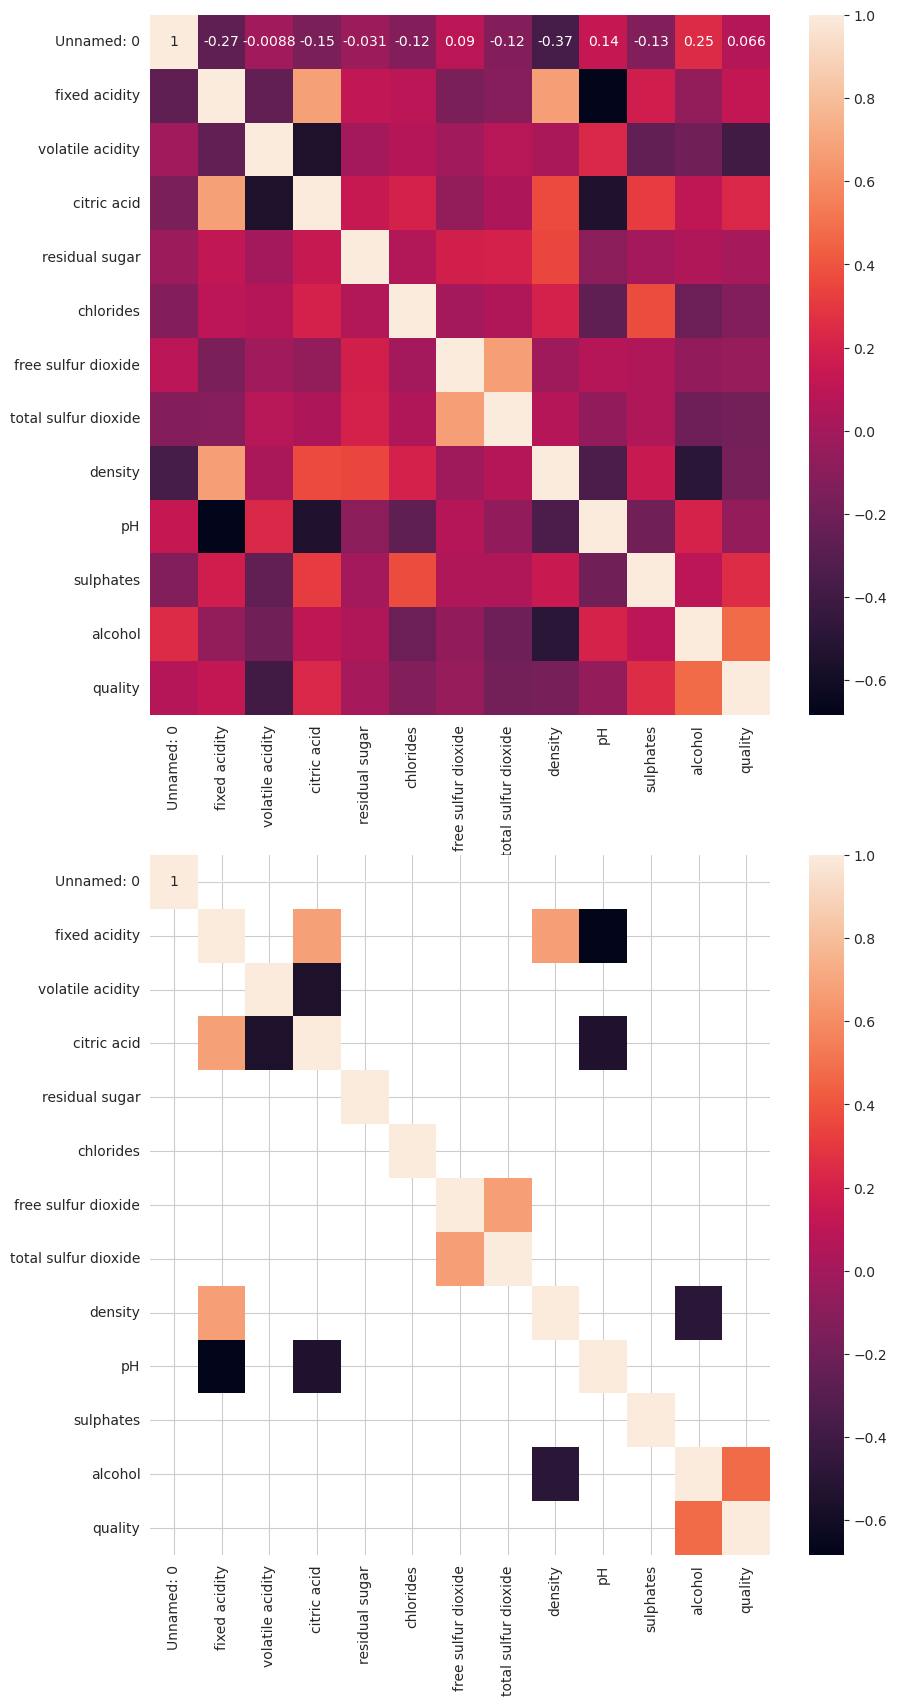

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = data.corr()

# create scatter plots of all the pairs 
plt.figure(figsize=(10, 20))
plt.subplot(211)
sns.heatmap(corr, annot=True)

high_corr = corr.where(abs(corr) > 0.4)
plt.subplot(212)
sns.heatmap(high_corr, annot=True)
plt.show()

from the correlation matrix i.e. the heatmap we can see that the highly correlated pairs are 
- (fixed acidity, citric acid, +),  (fixed acidity, density, +),  (fixed acidity, pH, -)
- (volatile acidity, citric acid, -)
- (pH, citric acid, -)
- (total sulfur dioxide, free sulfur dioxide, +)
- (alcohol, density, -)
- (quality, alcohol, +) 

In [48]:
X = np.asarray(data.iloc[:100, :-1])
Y = np.asarray(data.iloc[:100, -1])
X_test = np.asarray(data.iloc[100:150, :-1])
Y_test = np.asarray(data.iloc[100:150, -1])

# Part 2
Linear Regression weight formula:
$$ \mathbf{w} = \left( \mathbf{X}^\top \mathbf{X})^{-1} \right \mathbf{X}^\top \mathbf{y} \Rightarrow \mathbf{w} = \mathbf{X}^+ \mathbf{y}$$
Ridge Regression weight formula:
$$ \mathbf{w} = \left( \mathbf{X}^\top \mathbf{X} + \lambda \cdot \mathbf{I} \right)^{-1} \cdot \mathbf{X}^\top \cdot \mathbf{y} $$


In [45]:
import numpy as np
from numpy.linalg import inv

# Linear Regression
w = inv(X.T @ X) @ X.T @ Y

# Ridge Regression
w_r = lambda _l: np.linalg.inv(X.T @ X + _l * np.eye(X.shape[1])) @ X.T @ Y

w_r_10, w_r_100, w_r_200 = w_r(10), w_r(100), w_r(200)

Plotting the weights

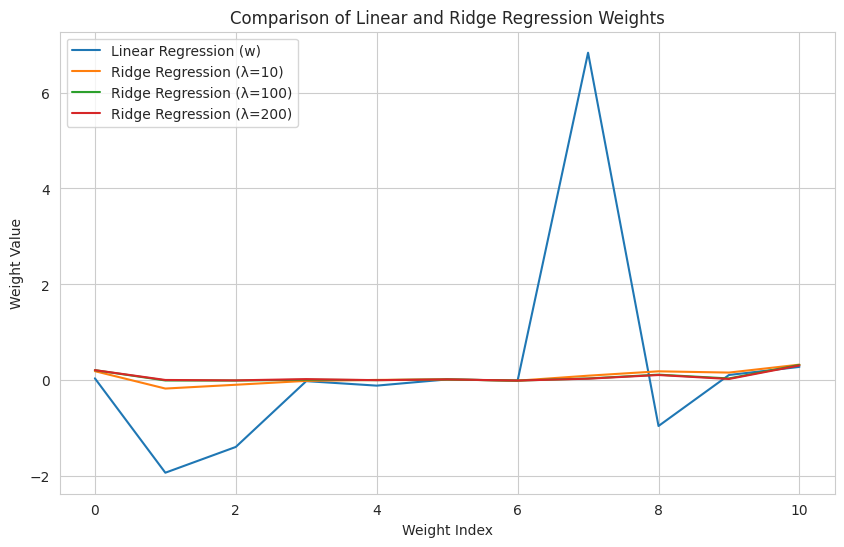

In [46]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(w, label='Linear Regression (w)')
plt.plot(w_r_10, label='Ridge Regression (λ=10)')
plt.plot(w_r_100, label='Ridge Regression (λ=100)')
plt.plot(w_r_200, label='Ridge Regression (λ=200)')

plt.title('Comparison of Linear and Ridge Regression Weights')
plt.xlabel('Weight Index')
plt.ylabel('Weight Value')

plt.legend()

plt.show()

Two things are straightforward from the plot above: 
- Since weight decay (L2 loss) has been used in Ridge Regression the weights have generally smaller values, the greater the λ the smaller the values of the weights.
- Since not all attributes are highly correlated the obvious happened and some weights have very small values, meaning that some attributes have very small impact on the result. 

A good way to get simpler weights would be to use L1 loss because then the small valued weights would end up with zero values.
Also since not all the variables are useful some kind of component analysis could be useful to get  rid of the low info gain attributes

Evaluation with RMSE
$$ \text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (\hat{y}_i - y_i)^2} $$


In [64]:
def calc_rmse(_X, _Y):
    y_pred = [w_i @ _X.T for w_i in [w, w_r_10, w_r_100, w_r_200]]
    rmse = [np.sqrt(sum(_Y - y_i) ** 2)/len(y_pred) for y_i in y_pred]
    return rmse

# Train 
print(f'Train RMSE:\n{calc_rmse(X, Y)}\nTest RMSE:\n{calc_rmse(X_test, Y_test)}')

Train RMSE:
[0.00027317616972866166, 0.2433519846861174, 0.9709019133401842, 1.722949291019658]
Test RMSE:
[2.279020633087578, 1.5609199581132982, 1.826274308097586, 2.2584927200838147]


The reason that the evaluation on test set values change this way is due to the form of the CrossValidation plot of lambda in Regression. The format is a parabola curved upwards and seems that the l = 100 point is the best of the three meaning that there we have the smallest error. Similar form to the one below:

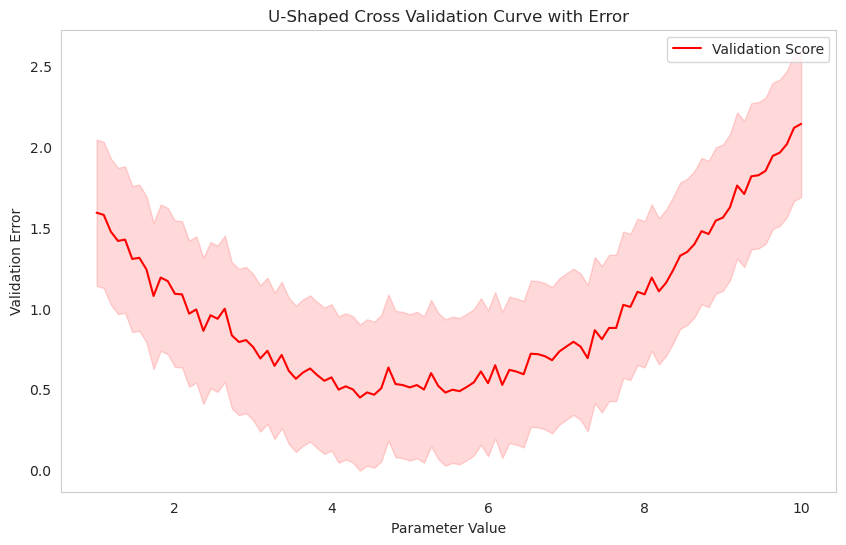

In [9]:
# Creating a U-shaped cross-validation curve with error
import numpy as np
import matplotlib.pyplot as plt

# Generating a U-shaped curve for validation error
param_range = np.linspace(1, 10, 100)
validation_scores = (param_range - 5)**2 / 15 + 0.5
validation_scores += np.random.normal(0, 0.05, size=validation_scores.shape)  # Adding some noise

# Calculating mean and standard deviation for illustration
validation_scores_mean = np.mean(validation_scores)
validation_scores_std = np.std(validation_scores)

# Plotting
plt.figure(figsize=(10, 6))
plt.title("U-Shaped Cross Validation Curve with Error")

plt.plot(param_range, validation_scores, color="red", label="Validation Score")
plt.fill_between(param_range, 
                 validation_scores - validation_scores_std, 
                 validation_scores + validation_scores_std, 
                 color="red", alpha=0.15)

plt.xlabel("Parameter Value")
plt.ylabel("Validation Error")
plt.legend(loc="best")
plt.grid()
plt.show()

